Epoch 1/20


<ipython-input-2-d9bd0416c044>:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.1414 - val_loss: 0.0219
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0193 - val_loss: 0.0142
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0134 - val_loss: 0.0105
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0113 - val_loss: 0.0094
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0111 - val_loss: 0.0093
Epoch 6/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0112 - val_loss: 0.0104
Epoch 7/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0111 - val_loss: 0.0092
Epoch 8/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0114 - val_loss: 0.0092
Epoch 9/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0100 - val_loss: 0.0110
Epoch 10/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0111 - val_loss: 0.0095
Epoch 11/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0095 - val_loss: 0.0101
Epoch 12/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0103 - val_loss: 0.

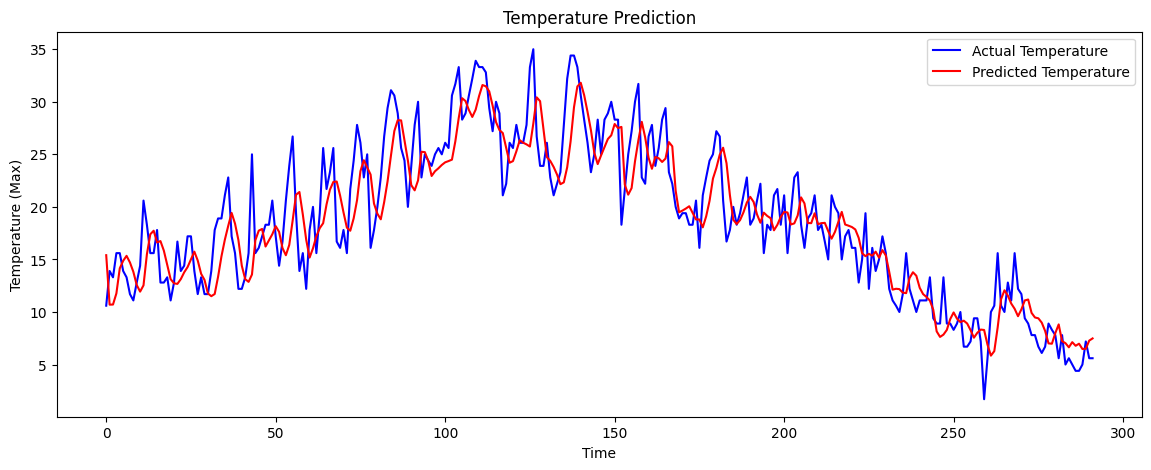

In [2]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error

# Loading the dataset
data = pd.read_csv('/content/seattle-weather.csv')  # Replace with the path to your dataset

# Data preprocessing
# Converting 'date' to datetime format
data['date'] = pd.to_datetime(data['date'])

# Handling missing values
data.fillna(method='ffill', inplace=True)

# Normalizing the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['precipitation', 'temp_max', 'temp_min', 'wind']])

# Creating a DataFrame for scaled data
scaled_df = pd.DataFrame(scaled_data, columns=['precipitation', 'temp_max', 'temp_min', 'wind'])

# Feature engineering
# Creating lag features (using past 3 days' data to predict the next day's max temp)
def create_features(df, lag=3):
    X, y = [], []
    for i in range(lag, len(df)):
        X.append(df[i-lag:i])
        y.append(df[i, 1])  # temp_max is at index 1 in scaled_df
    return np.array(X), np.array(y)

lag = 3
X, y = create_features(scaled_data, lag)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Building the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compiling the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Training the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Making predictions
y_pred = model.predict(X_test)

# Inverse scaling to get actual temperature values
# Inverse scaling to get actual temperature values
# Create an array with the same shape as the original data, where we only change the temp_max column
y_test_actual = scaler.inverse_transform(np.column_stack([np.zeros(y_test.shape[0]), y_test, np.zeros(y_test.shape[0]), np.zeros(y_test.shape[0])]))[:, 1]
y_pred_actual = scaler.inverse_transform(np.column_stack([np.zeros(y_pred.shape[0]), y_pred[:,0], np.zeros(y_pred.shape[0]), np.zeros(y_pred.shape[0])]))[:, 1]


# Model evaluation
mse = mean_squared_error(y_test_actual, y_pred_actual)
print(f"Mean Squared Error: {mse}")

# Visualizing the predictions versus actual values
plt.figure(figsize=(14, 5))
plt.plot(y_test_actual, color='blue', label='Actual Temperature')
plt.plot(y_pred_actual, color='red', label='Predicted Temperature')
plt.title('Temperature Prediction')
plt.xlabel('Time')
plt.ylabel('Temperature (Max)')
plt.legend()
plt.show()
